In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import *
from sklearn.metrics import classification_report, accuracy_score
from google.colab import drive

In [3]:
# Set directories
train_dir = '/content/drive/MyDrive/Alzheimer_s Dataset/test'
test_dir = '/content/drive/MyDrive/Alzheimer_s Dataset/test'

In [4]:
# Get class names
class_names = os.listdir(train_dir)
class_names

['ModerateDemented', 'MildDemented', 'NonDemented', 'VeryMildDemented']

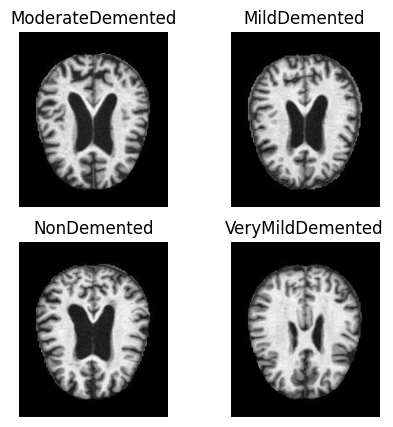

In [5]:
# Print sample images from each class
plt.figure(figsize=(5, 5))
for i, class_name in enumerate(class_names):
    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_dir, class_name)))
    img_path = os.path.join(train_dir, class_name, img_name)

    # Read and display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [6]:
# Function to preprocess images
def preprocess_image(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (112, 112))
    # Normalization: As the pixel values range from 0 to 256, apart from 0 the range is 255.
    # So dividing all the values by 255 will convert it to range from 0 to 1. []
    image = image / 255.0
    return image, label

In [7]:
# Load image paths and labels
X = []
y = []
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        X.append(os.path.join(class_dir, img_name))
        y.append(class_name)

In [8]:
# Split data into training and testing sets while maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
# Count number of samples in each class for training and testing sets
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

In [10]:
# Print the count of each class for training set before upsampling
print("Training Set Class Counts (Before Upsampling):")
for class_name, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"{class_name}: {count} samples")

Training Set Class Counts (Before Upsampling):
MildDemented: 143 samples
ModerateDemented: 10 samples
NonDemented: 512 samples
VeryMildDemented: 358 samples


In [11]:
print("\nTesting Set Class Counts:")
for class_name, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"{class_name}: {count} samples")


Testing Set Class Counts:
MildDemented: 36 samples
ModerateDemented: 2 samples
NonDemented: 128 samples
VeryMildDemented: 90 samples


In [12]:
# Function to upsample minority classes
def upsample_minority_classes(X_train, y_train):
    df_train = pd.DataFrame({'image_path': X_train, 'class': y_train})
    class_counts = df_train['class'].value_counts()
    max_class_count = class_counts.max()

    dfs_upsampled = []
    for class_name, count in class_counts.items():
        df_class = df_train[df_train['class'] == class_name]
        if count < max_class_count:
            df_upsampled = resample(df_class, replace=True, n_samples=max_class_count, random_state=42)
            dfs_upsampled.append(df_upsampled)
        else:
            dfs_upsampled.append(df_class)

    df_train_upsampled = pd.concat(dfs_upsampled)
    X_train_upsampled = df_train_upsampled['image_path'].values
    y_train_upsampled = df_train_upsampled['class'].values
    return X_train_upsampled, y_train_upsampled

In [13]:
# Function to upsample minority classes in test data
def upsample_test_minority_classes(X_test, y_test):
    # Combine features and labels into a DataFrame
    df_test = pd.DataFrame({'image_path': X_test, 'label': y_test})

    # Separate majority and minority classes
    df_majority_test = df_test[df_test['label'].isin(['NonDemented'])]
    df_minority1_test = df_test[df_test['label'].isin(['MildDemented'])]
    df_minority2_test = df_test[df_test['label'].isin(['ModerateDemented'])]
    df_minority3_test = df_test[df_test['label'].isin(['VeryMildDemented'])]

    # Upsample minority classes
    df_minority_upsampled1_test = resample(df_minority1_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled2_test = resample(df_minority2_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled3_test = resample(df_minority3_test, replace=True, n_samples=len(df_majority_test), random_state=42)

    # Combine majority class with upsampled minority classes
    df_upsampled_test = pd.concat([df_majority_test, df_minority_upsampled1_test, df_minority_upsampled2_test, df_minority_upsampled3_test])

    # Shuffle the dataframe
    df_upsampled_test = df_upsampled_test.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features and labels
    X_test_upsampled = df_upsampled_test['image_path'].values
    y_test_upsampled = df_upsampled_test['label'].values

    return X_test_upsampled, y_test_upsampled

In [14]:
# Upsample minority classes in the training set
X_train_upsampled, y_train_upsampled = upsample_minority_classes(X_train, y_train)

In [15]:
# Upsample minority classes in the test set
X_test_upsampled, y_test_upsampled = upsample_test_minority_classes(X_test, y_test)

Data augmentation

In [16]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale=1./255)

In [17]:
# Data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train_upsampled, 'class': y_train_upsampled}),
    x_col='image_path',
    y_col='class',
    target_size=(112, 112),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 2048 validated image filenames belonging to 4 classes.


In [19]:
# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test_upsampled, 'label': y_test_upsampled}),
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(112, 112),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

Found 512 validated image filenames belonging to 4 classes.


In [20]:
# After applying ImageDataGenerator, you can check the count of each label
train_label_counts = train_generator.classes
test_label_counts = test_generator.classes

# Count occurrences of each class label
train_label_counts = np.bincount(train_label_counts)
test_label_counts = np.bincount(test_label_counts)

In [21]:
# Print the count of each class for the training set
print("Training Set Class Counts (After Augmentation):")
for i, count in enumerate(train_label_counts):
    print(f"Class {i}: {count} samples")

Training Set Class Counts (After Augmentation):
Class 0: 512 samples
Class 1: 512 samples
Class 2: 512 samples
Class 3: 512 samples


In [22]:
# Print the count of each class for the testing set
print("\nTesting Set Class Counts:")
for i, count in enumerate(test_label_counts):
    print(f"Class {i}: {count} samples")


Testing Set Class Counts:
Class 0: 128 samples
Class 1: 128 samples
Class 2: 128 samples
Class 3: 128 samples


Build Model

In [23]:
# Define the model architecture
cnnmodel = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(112, 112, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [24]:
# Compile the model
cnnmodel.compile(optimizer='adam',
             loss='categorical_crossentropy',
   metrics=['accuracy'])

In [25]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath="best_weights.weights.h5", monitor='val_loss',
                                   save_best_only=True, save_weights_only=True, verbose=1)

In [110]:
# Train model
history = cnnmodel.fit(train_generator, validation_data=test_generator, epochs=50 ,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 2.3727 - accuracy: 0.2505
Epoch 1: val_loss improved from inf to 1.38632, saving model to best_weights.weights.h5
32/32 [==============================] - 23s 662ms/step - loss: 2.3727 - accuracy: 0.2505 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 1.3864 - accuracy: 0.2500
Epoch 2: val_loss improved from 1.38632 to 1.38631, saving model to best_weights.weights.h5
32/32 [==============================] - 20s 630ms/step - loss: 1.3864 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 1.3863 - accuracy: 0.2432
Epoch 3: val_loss improved from 1.38631 to 1.38628, saving model to best_weights.weights.h5
32/32 [==============================] - 25s 775ms/step - loss: 1.3863 - accuracy: 0.2432 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/50
32/32 [==============================] 

In [119]:
# Display model summary
cnnmodel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 108, 108, 32)      832       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 flatten_6 (Flatten)         (None, 173056)            0         
                                                                 
 dropout_6 (Dropout)         (None, 173056)            0         
                                                                 
 dense_12 (Dense)            (None, 512)               88605184  
                                                      

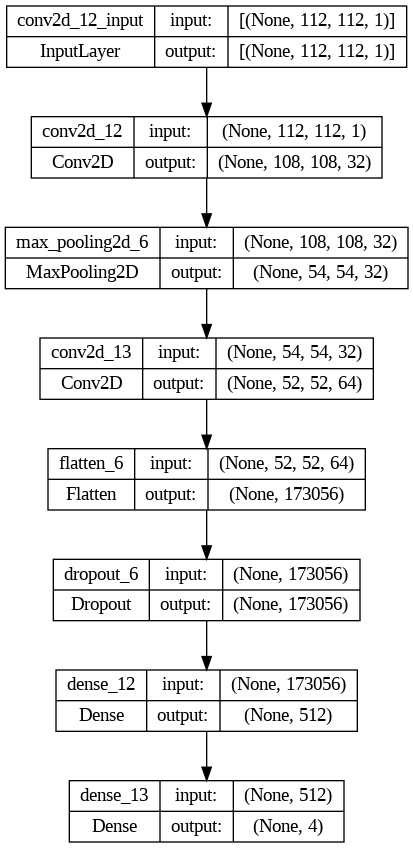

In [112]:
plot_model(cnnmodel, to_file='model_architecture.png', show_shapes=True)

In [113]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnnmodel.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 [==============================] - 2s 189ms/step - loss: 0.7802 - accuracy: 0.6445
Test Loss: 0.7801851034164429
Test Accuracy: 0.64453125


In [114]:
# Generate predictions
test_predictions = cnnmodel.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

8/8 [==============================] - 2s 185ms/step


In [115]:
# True classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [116]:
# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

                  precision    recall  f1-score   support

    MildDemented       0.25      0.39      0.30       128
ModerateDemented       0.24      0.24      0.24       128
     NonDemented       0.29      0.32      0.30       128
VeryMildDemented       0.24      0.07      0.11       128

        accuracy                           0.26       512
       macro avg       0.25      0.26      0.24       512
    weighted avg       0.25      0.26      0.24       512



In [117]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(labels=true_classes, predictions=predicted_classes)
conf_matrix

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[50, 36, 32, 10],
       [51, 31, 40,  6],
       [46, 28, 41, 13],
       [56, 34, 29,  9]], dtype=int32)>

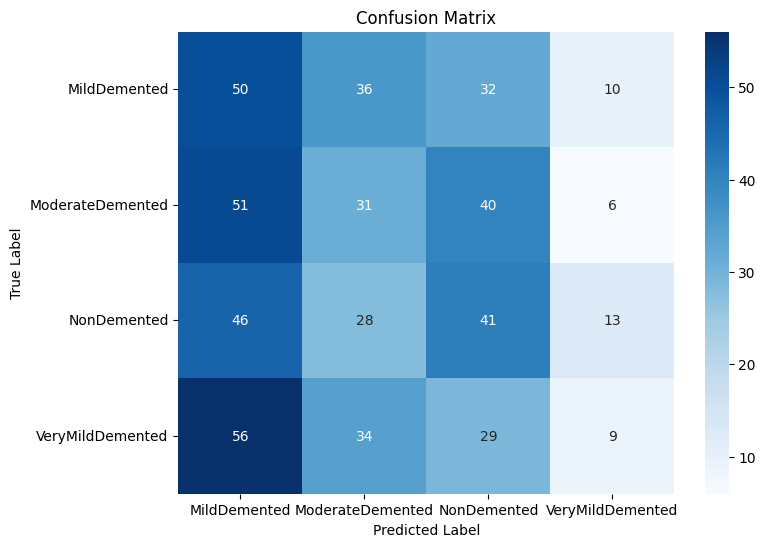

In [118]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()